# Интерпретация A/B теста

Ход исследования:
1. Разведочный анализ (EDA)
2. [Проверка данных на нормальность](https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/)
3. Выбор теста для проверки гипотезы
4. Проведение статистического теста
5. Обработка экстремальных выбросов
6. Проведение тестов для очищенных данных
7. Заключение

In [2]:
# подключение библиотек
import pandas as pd
%pylab inline
import seaborn as sns
from scipy import stats
from statsmodels.graphics.gofplots import qqplot

sns.set_style('darkgrid')

Populating the interactive namespace from numpy and matplotlib


In [3]:
# считывание данных
df = pd.read_csv('../data_in/test_data.csv', index_col='user_id')

## Смотрим на данные

In [4]:
df.head()

,group,commission
user_id,,
0,test,3.246642
1,test,10.516064
2,control,1.529808
3,test,5.645316
4,control,13.602017


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 2 columns):
group         2000 non-null object
commission    2000 non-null float64
dtypes: float64(1), object(1)
memory usage: 46.9+ KB


In [6]:
df.describe()

,commission
count,2000.000000
mean,5.661489
std,7.291695
min,0.069963
25%,2.014997
50%,3.700463
75%,6.709476
max,103.144899


Максимальное значение очень далеко отстоит от основной выборки.  
Необходимо визуализировать и проверить выборку на нормальность

True


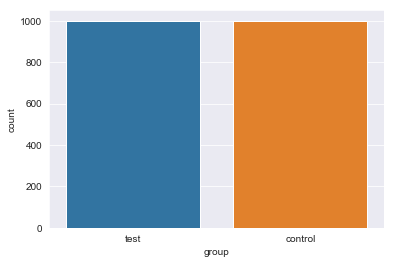

In [7]:
sns.countplot(df['group']);
are_groups_equal = df[df['group']=='test'].shape == df[df['group']=='control'].shape
print(are_groups_equal)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


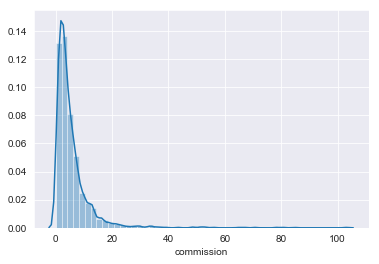

In [8]:
sns.distplot(df['commission']);

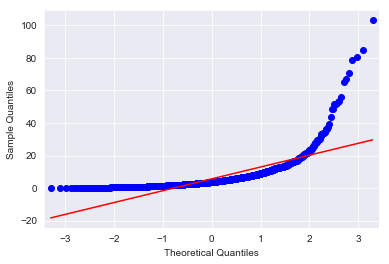

In [9]:
qqplot(df['commission'], line='s');

In [10]:
# используем тест чтобы проверить выборку на нормальность

stat, p = stats.shapiro(df['commission'])
alpha = 1e-3

print("Нулевая гипотеза: выборка распределена нормально")
print("Тест: Шапиро-Уилка")
print(f"W: {stat}, p-value: {p}")
print('\nВывод')
if p < alpha:
    print("Можем отвергнуть нулевую гипотезу")
else:
    print("Не можем отвергнуть нулевую гипотезу")

Нулевая гипотеза: выборка распределена нормально
Тест: Шапиро-Уилка
W: 0.5585280656814575, p-value: 0.0

Вывод
Можем отвергнуть нулевую гипотезу


### Выводы
По QQ plot и результатам теста Шапиро-Уилка делаем заключение что данные распределены не нормально.  
___

У нас есть три варианта, что мы можем делать далее:

1. Очистить данные от выбросов
2. Преобразовать данные к нормальным, например с помощью логарифма
3. Использовать bootstrap выборки
4. Использовать непараметрический ранговый U-тест, вместо t-теста


Минусы каждого из способов:
1. Теряем клиентов, которые много денег принесли в продукт
2. Переходим от понятных денег к непонятному бизнесу логарифму денег
3. Затратный по вычислительным ресурсам и не устойчив к выбросам
4. Трудноинтерпретируе

___

Выбираем способ 4, U-тест

U тест непараметрический, соответственно нет ограничений по виду распределения данных.  
Есть следующие ограничения:

1. Обе выборки простые, объединённая выборка независима (одно наблюдение встречается 1 раз);
2. Выборки взяты из неизвестных непрерывных распределений F(x) и G(y) соответственно

In [11]:
# проверяем что каждое значение встречается только 1 раз
df['commission'].value_counts().head()

18.406194    1
2.593625     1
4.982359     1
2.612242     1
2.342356     1
Name: commission, dtype: int64

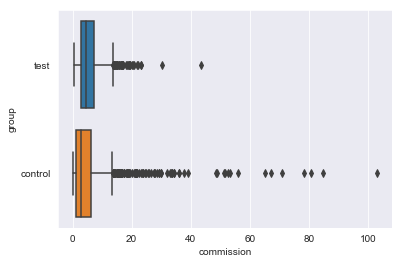

In [15]:
sns.boxplot(x='commission', y='group', data=df);

In [27]:
control = df[df['group'] == 'control']['commission']
test = df[df['group'] == 'test']['commission']

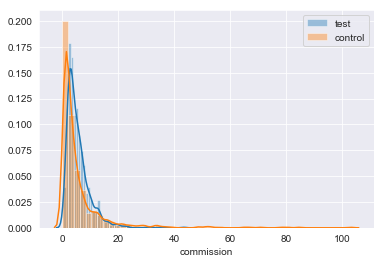

In [38]:
sns.distplot(test);
sns.distplot(control);
plt.legend(labels=['test', 'control']);

In [34]:
print("H1: P(x < y) > 1/2")

U, p = stats.mannwhitneyu(x=test, 
                   y=control,
                   use_continuity=True,
                   alternative='greater')

print(f'U-статистика: {U}, \np-value: {p} \n')
alpha = 0.05
if p > alpha:
    print('Одинаковые распределения комиссии в контрольной группе и эксперементальной')
else:
    print('Значения из эксперементальной группы ниже значений из контрольной с вероятностью выше 0.5')

H1: P(x < y) > 1/2
U-статистика: 632998.0, 
p-value: 3.546303863405979e-25 

Значения из эксперементальной группы ниже значений из контрольной с вероятностью выше 0.5


## Работаем с выбросами

In [42]:
def iqr_bounds(dataset):
    q1, q3= np.percentile(control,[25,75])
    iqr = iqr = q3 - q1
    lower_bound = q1 -(1.5 * iqr) 
    upper_bound = q3 +(1.5 * iqr) 
    return lower_bound, upper_bound

In [45]:
l_control, u_control = iqr_bounds(control)
(control > u_control).sum()

92

In [46]:
l_test, u_test = iqr_bounds(test)
(test > u_test).sum()

42

In [55]:
cq99 = control.quantile(0.99)
tq99 = test.quantile(0.99)
print(cq99, tq99)

51.482651728310174 19.55388586824799


In [56]:
control_clean = control[control < cq99]
test_clean = test[test < tq99]

In [53]:
print("H1: P(x < y) > 1/2")

U, p = stats.mannwhitneyu(x=test_clean, 
                   y=control_clean,
                   use_continuity=True,
                   alternative='greater')

print(f'U-статистика: {U}, \np-value: {p} \n')
alpha = 0.05
if p > alpha:
    print('Одинаковые распределения комиссии в контрольной группе и эксперементальной')
else:
    print('Значения из эксперементальной группы ниже значений из контрольной с вероятностью выше 0.5')

H1: P(x < y) > 1/2
U-статистика: 623411.0, 
p-value: 5.098649402857545e-26 

Значения из эксперементальной группы ниже значений из контрольной с вероятностью выше 0.5


In [59]:
print("H1: P(x < y) > 1/2")

U, p = stats.mannwhitneyu(x=test, 
                   y=control_clean,
                   use_continuity=True,
                   alternative='greater')

print(f'U-статистика: {U}, \np-value: {p} \n')
alpha = 0.05
if p > alpha:
    print('Одинаковые распределения комиссии в контрольной группе и эксперементальной')
else:
    print('Значения из эксперементальной группы ниже значений из контрольной с вероятностью выше 0.5')

H1: P(x < y) > 1/2
U-статистика: 632998.0, 
p-value: 2.454783978248039e-27 

Значения из эксперементальной группы ниже значений из контрольной с вероятностью выше 0.5


## Заключение

Исходя из непараметрического U-теста проведенного для полных выборок и выборок очищенных от экстремальных выбросов 
делаем заключение что фича не увеличивает размер комиссии получаемый от клиента.